# SVM

In [1]:
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import plotly.express as px

# Train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Word2Vec Embedding
import gensim
from gensim.models import Word2Vec
from sklearn.utils import resample


from gensim.models import FastText
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors

from tensorflow import keras
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ELMo Embedding
import tensorflow as tf
import tensorflow_hub as hub
import h5py

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score 

## Load Cleaned Dataset

In [2]:
# Read from CSV file
df = pd.read_csv('cleaned_combined_data.csv')
df.head()

Categorization  \
0                     Envy to other is swallowing me   
1  Nothin outta the ordinary. Paradise. Job stres...   
2  Almost 49 and the chasm of emptiness has never...   
3                                    I’m happy again   
4  Is it possible to recover from such a traumati...   

                                                Body  Label  \
0  Im from developingcountry, Indonesia , and for...      1   
1  Um hello ....well many can relate im sure. Aft...      1   
2  I’ve been diagnosed severe bi polar where you ...      1   
3  After my closest friend left me in April, I ha...      0   
4  I am only 15, and yet I feel my life is alread...      1   

                                        Cleaned Text  \
0  im developingcountry indonesia temporary work ...   
1  um hello well many relate im sure today im con...   
2  ive diagnosed severe bi polar longer even get ...   
3  closest friend left april finally let go reali...   
4  15 yet feel life already pit emptiness stomach...   

                   Cleaned Text with N lemmatization  \
0  im developingcountry indonesia temporary work ...   
1  um hello well many relate im sure today im con...   
2  ive diagnosed severe bi polar longer even get ...   
3  closest friend left april finally let go reali...   
4  15 yet feel life already pit emptiness stomach...   

                   Cleaned Text with V lemmatization  \
0  im developingcountry indonesia temporary work ...   
1  um hello well many relate im sure today im con...   
2  ive diagnose severe bi polar longer even get g...   
3  closest friend leave april finally let go real...   
4  15 yet feel life already pit emptiness stomach...   

                   Cleaned Text with A lemmatization  
0  im developingcountry indonesia temporary work ...  
1  um hello well many relate im sure today im con...  
2  ive diagnosed severe bi polar long even get go...  
3  close friend left april finally let go realize...  
4  15 yet feel life already pit emptiness stomach...

In [3]:
rows_with_nan = df[df.isna().any(axis=1)]
print(rows_with_nan)

                               Categorization Body  Label Cleaned Text  \
796  I wish Somebody could understand my pain    (      1          NaN   

    Cleaned Text with N lemmatization Cleaned Text with V lemmatization  \
796                               NaN                               NaN   

    Cleaned Text with A lemmatization  
796                               NaN  


In [4]:
# Drop rows with NaN values in place
df.dropna(inplace=True)

## Hyperparameter tuning to determine best parameters for Random Forest model

In [5]:
# Import the necessary libraries
from sklearn.svm import SVC

# Define the features (X) and the target (y)
X = df["Cleaned Text"]
y = df["Label"]
print(df["Label"].unique())

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create a pipeline with CountVectorizer and TfidfTransformer
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Text to word-count vector
    ('tfidf', TfidfTransformer()),  # TF-IDF transformation
])

# Fit and transform the text data to numerical features using the pipeline
X_train_vec = pipeline.fit_transform(X_train)
X_valid_vec = pipeline.transform(X_valid)
X_test_vec = pipeline.transform(X_test)

# Now, you have X_train_vec, y_train for training, X_valid_vec, y_valid for hyperparameter tuning,
# and X_test_vec, y_test for final evaluation, all in numerical format with TF-IDF transformation.

# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel as needed (e.g., 'linear', 'rbf', 'poly', etc.)

# Define the hyperparameter grid for the SVM model
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types to test
}

# Create the grid search with recall scoring
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='recall')

# Fit the grid search to the training data with numerical features
grid_search.fit(X_train_vec, y_train)

[1 0]


GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='recall')

In [6]:
best_hyperparameters = grid_search.best_params_
best_model = grid_search.best_estimator_

In [39]:
print(best_hyperparameters)

{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


In [7]:
# Use the best model to make predictions on the validation set
y_valid_pred = best_model.predict(X_valid_vec)

# Calculate the recall on the validation set
recall = recall_score(y_valid, y_valid_pred)

# Print the recall
print(f"Validation set Recall with best hyperparameters: {recall:.4f}")

Validation set Recall with best hyperparameters: 1.0000


In [13]:
# Create an SVM model with the best hyperparameters
final_model = SVC(random_state=42, **best_hyperparameters, probability=True)

# Fit the SVM model to the training data with numerical features
final_model.fit(X_train_vec, y_train)

SVC(C=0.1, gamma=0.001, probability=True, random_state=42)

In [14]:
# Use the final model to make predictions on the test set
y_test_pred = final_model.predict(X_test_vec)

# Calculate the recall on the test set
recall = recall_score(y_test, y_test_pred)

# Print the recall
print(f"Test set Recall with final model: {recall:.4f}")

Test set Recall with final model: 1.0000


## Hypothesis 1: How does different text lemmatization affect the model results?

There are different parts of speech (pos) to lemmatize by
1. Noun (pos = 'n'):
- "cats" -> "cat"
- "dogs" -> "dog"
- "books" -> "book" 
2. Verb (pos = 'v')
- "running" -> "run"
- "eating" -> "eat"
- "swimming" -> "swim"
3. Adjectives (pos = "a")
- better -> "good"
- "happier" -> 'happy'
- "brighter" -> "bright"

We have 4 sets of columns - "Cleaned Text", "Cleaned Text with N lemmatization", "Cleaned Text with V lemmatization", "Cleaned Text with A lemmatization"

We'll now how lemmatization affects model results

### Model Function

Use of function for ease of model reuse
 
**Column used: Function input**

<u>**Standardised variables**</u>
- **Model: SVM**
- **Feature Extraction: CountVectorizer**
- **Feature Transformation: TfidfTransformer** 

<u>**Steps**</u>
1. Use of Stratified K-fold to split data
2. Create pipeline
3. Fit Model
4. Get results

In [15]:
def model_for_hypothesis_1(column_name):

    X1 = df[column_name] # features
    y = df['Label']

    # Create K-Fold splitter for 10 folds
    num_of_folds = 10
    skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    # List of accuracy for each fold
    k_fold_accuracy = []
    k_fold_classification_error = []
    k_fold_sensitivity = []
    k_fold_precision = []
    k_fold_specificity = []
    k_fold_f1_score = []

    auc_roc_scores = []
    fpr_values = []
    tpr_values = []

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    # Create a pipeline
    pipe = Pipeline([
        ('vect', CountVectorizer()),  # Text to word-count vector
        ('tfidf', TfidfTransformer()),  # TF-IDF transformation
        ('model', final_model)  # SVM model
    ])

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------


    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X1, y):
        X_train, X_test = X1.iloc[train_index], X1.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the pipeline on the training data for this fold
        pipe.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = pipe.predict(X_test)

        #confusion Matrix
        confusion = metrics.confusion_matrix(y_test, y_pred)
        
        # Access specific values of confusion matix using [row, column]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        TP = confusion[1, 1]
        
        # Calculate accuracy for the fold and append it
        accuracy = metrics.accuracy_score(y_test, y_pred)
        k_fold_accuracy.append(round(accuracy, 4))
        #print('The accuracy for each fold is:', k_fold_accuracy)
        
        # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
        classification_error = 1 - accuracy
        k_fold_classification_error.append(round(classification_error, 4))

        # Calculate sensitivity for the fold and append it
        sensitivity = metrics.recall_score(y_test, y_pred)
        k_fold_sensitivity.append(round(sensitivity, 4))

        # Calculate precision for the fold and append it
        precision = metrics.precision_score(y_test, y_pred)
        k_fold_precision.append(round(precision, 4))
        
        # Calculate specificity for the fold and append it
        specificity = TN / (TN + FP)
        k_fold_specificity.append(round(specificity, 4))
        
        # Calculate f1_score for the fold and append it
        f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
        k_fold_f1_score.append(round(f1_score, 4))
        
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        
        y_pred_proba = pipe.predict_proba(X_test)[:, 1]

        
        # Calculate the AUC-ROC score for this fold
        auc_roc_score = roc_auc_score(y_test, y_pred_proba)
        auc_roc_scores.append(auc_roc_score)

        # Calculate the fpr/tpr values for the ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        fpr_values.append(fpr)
        tpr_values.append(tpr)

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    print('The average accuracy is: {:.2f}%'.format(statistics.mean(k_fold_accuracy) * 100))
    print('The average classification error is: {:.2f}%'.format(statistics.mean(k_fold_classification_error) * 100))
    print('The average recall is: {:.2f}%'.format(statistics.mean(k_fold_sensitivity) * 100))
    print('The average precision is: {:.2f}%'.format(statistics.mean(k_fold_precision) * 100))
    print('The average specificity is: {:.2f}%'.format(statistics.mean(k_fold_specificity) * 100))
    print('The average f1 score is: {:.2f}%'.format(statistics.mean(k_fold_f1_score) * 100))

    weights = [len(test_index) / len(y) for _, test_index in skf.split(X1,y)]
    avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
    print('The average AUC Score is: {:.2f}%'.format(avg_auc_roc * 100))


### Base model

- **Column used: "Cleaned Text"**
Description:
"Cleaned Text" is preprocessed data without text lemmatization

In [16]:
model_for_hypothesis_1("Cleaned Text")

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 86.56%


### Model 1

- **Column used: "Cleaned Text with N lemmatization"**
Description:
"Cleaned Text with N lemmatization" is preprocessed data text lemmatization by Nouns

In [17]:
model_for_hypothesis_1("Cleaned Text with N lemmatization")

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 86.44%


### Model 2

- **Column used: "Cleaned Text with V lemmatization"**
Description:
"Cleaned Text with V lemmatization" is preprocessed data with text lemmatization by verbs

In [18]:
model_for_hypothesis_1("Cleaned Text with V lemmatization")

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 86.47%


### Model 3

- **Column used: "Cleaned Text with A lemmatization"**
Description:
"Cleaned Text with A lemmatization" is preprocessed data with text lemmatization by adjectives

In [19]:
model_for_hypothesis_1("Cleaned Text with A lemmatization")

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 86.60%


## Hypothesis 2: How does different text extraction methods affect the results?

<u>**Different Text Extraction methods**</u>

1. **Bag of Words (BoW) with TF-IDF transformation**: It creates a vector of word counts for each document.TF-IDF is used to assign weights to words based on their frequency within a document and their importance in the entire corpus. This step converts the BoW features into TF-IDF features.

2. **Word Embeddings**: Represent words as dense vectors in a continuous vector space. Word embeddings can be averaged or combined to represent documents.

    - Examples of Word embedding models: Word2Vec, GloVe, and FastText 
    
3. **Doc2Vec**: An extension of Word2Vec that learns document-level embeddings, allowing you to represent entire documents as vectors.

### Model Function

Use of function for ease of model reuse
 

<u>**Steps**</u>
1. Use of Stratified K-fold to split data
2. Fit Model
3. Get results

In [20]:
def model_for_hypothesis_2(feature, label, pipe):

    # Create K-Fold splitter for 10 folds
    num_of_folds = 10
    skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    # List of accuracy for each fold
    k_fold_accuracy = []
    k_fold_classification_error = []
    k_fold_sensitivity = []
    k_fold_precision = []
    k_fold_specificity = []
    k_fold_f1_score = []

    auc_roc_scores = []
    fpr_values = []
    tpr_values = []

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------


    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(feature, label):

        if isinstance(feature, np.ndarray):
            # the feature matrix derived from word embedding result in numpy.ndarray' object
            X_train, X_test = feature[train_index], feature[test_index]
        else:
            X_train, X_test = feature.iloc[train_index], feature.iloc[test_index]


        y_train, y_test = label.iloc[train_index], label.iloc[test_index]

        # Fit the pipeline on the training data for this fold
        pipe.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = pipe.predict(X_test)

        #confusion Matrix
        confusion = metrics.confusion_matrix(y_test, y_pred)
        
        # Access specific values of confusion matix using [row, column]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        TP = confusion[1, 1]
        
        # Calculate accuracy for the fold and append it
        accuracy = metrics.accuracy_score(y_test, y_pred)
        k_fold_accuracy.append(round(accuracy, 4))
        #print('The accuracy for each fold is:', k_fold_accuracy)
        
        # Calculate classification error derived from accuracy (we minus it against 1) for the fold and append it
        classification_error = 1 - accuracy
        k_fold_classification_error.append(round(classification_error, 4))

        # Calculate sensitivity for the fold and append it
        sensitivity = metrics.recall_score(y_test, y_pred)
        k_fold_sensitivity.append(round(sensitivity, 4))

        # Calculate precision for the fold and append it
        precision = metrics.precision_score(y_test, y_pred)
        k_fold_precision.append(round(precision, 4))
        
        # Calculate specificity for the fold and append it
        specificity = TN / (TN + FP)
        k_fold_specificity.append(round(specificity, 4))
        
        # Calculate f1_score for the fold and append it
        f1_score = (2 * sensitivity * precision) / (sensitivity + precision)
        k_fold_f1_score.append(round(f1_score, 4))
        
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        
        y_pred_proba = pipe.predict_proba(X_test)[:, 1]

        
        # Calculate the AUC-ROC score for this fold
        auc_roc_score = roc_auc_score(y_test, y_pred_proba)
        auc_roc_scores.append(auc_roc_score)

        # Calculate the fpr/tpr values for the ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        fpr_values.append(fpr)
        tpr_values.append(tpr)

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    print('The average accuracy is: {:.2f}%'.format(statistics.mean(k_fold_accuracy) * 100))
    print('The average classification error is: {:.2f}%'.format(statistics.mean(k_fold_classification_error) * 100))
    print('The average recall is: {:.2f}%'.format(statistics.mean(k_fold_sensitivity) * 100))
    print('The average precision is: {:.2f}%'.format(statistics.mean(k_fold_precision) * 100))
    print('The average specificity is: {:.2f}%'.format(statistics.mean(k_fold_specificity) * 100))
    print('The average f1 score is: {:.2f}%'.format(statistics.mean(k_fold_f1_score) * 100))

    weights = [len(test_index) / len(y) for _, test_index in skf.split(feature,y)]
    avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
    print('The average AUC Score is: {:.2f}%'.format(avg_auc_roc * 100))


    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    # Plot AUCROC Curve
    # Calculate the (1) average false positive rate, (2) average true positive rate

    # Get the maximum length of the arrays in the list
    max_length_fpr = max(len(a) for a in fpr_values)
    max_length_tpr = max(len(a) for a in tpr_values)

    # Pad each array in the list with zeros so that they have the same length
    padded_fpr = np.array([np.pad(a, (0, max_length_fpr - len(a)), mode='constant') for a in fpr_values])
    padded_tpr = np.array([np.pad(a, (0, max_length_tpr - len(a)), mode='constant') for a in tpr_values])

    weights = [len(test_index) / len(y) for _, test_index in skf.split(feature,y)]
    avg_auc_roc = np.average(auc_roc_scores, weights=weights, axis=0)
    avg_fpr_value = np.average(padded_fpr, weights=weights, axis=0)
    avg_tpr_value = np.average(padded_tpr, weights=weights, axis=0)

    # Plot AUC using area chart
    fig = px.area(
        x = avg_fpr_value, y = avg_tpr_value,
        title = f'ROC Curve (AUC={avg_auc_roc:.4f})',
        labels = dict(x = 'Average False Positive Rate', y = 'Average True Positive Rate'),
        width = 700, height = 700
    )

    # This part adds formatting & plots the dashed line at AUC=0.5 
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')

    fig.show()


    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

    x_axis = [i for i in range(1, num_of_folds + 1)]
    fig = px.scatter( x = x_axis, y = auc_roc_scores,
                    labels = {"x": "K-Fold", "y": "AUC Score"},
                    trendline = 'ols',
                    title = 'AUC Values for the the each K-Fold' # add title parameter
    )

    fig.show()

### Base Model

- **Column used: "Cleaned Text"**
- **Model: SVM**
- **Feature Extraction: Bag of Words (BoW) with TF-IDF transformation**
Explanation:
CountVectorizer is a feature extraction step. It converts text data into a matrix of word counts, where each row represents a document, and each column represents a unique word or token in the corpus. This step extracts features from the text.
- **Feature Transformation: TfidfTransformer** 
Explanation:
TfidfTransformer is a feature transformation step. It takes the count matrix produced by CountVectorizer and applies the TF-IDF (Term Frequency-Inverse Document Frequency) transformation to it. This transformation adjusts the word counts to emphasize the importance of words in the text data. It doesn't extract new features but transforms the existing features.

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 86.56%


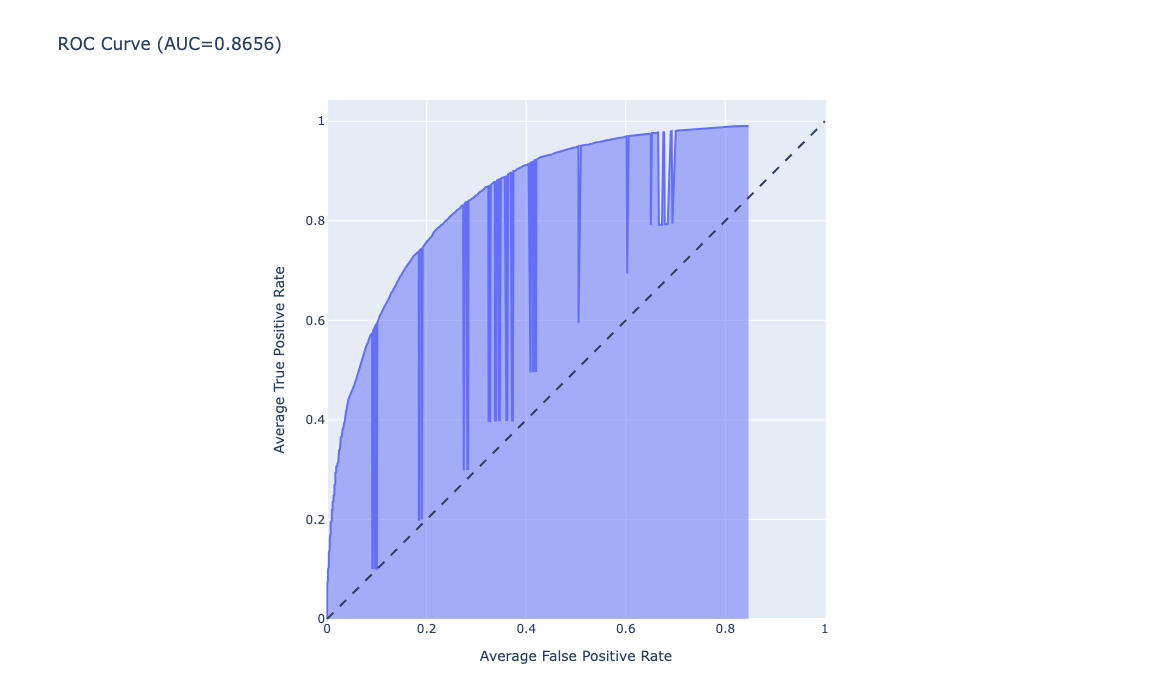

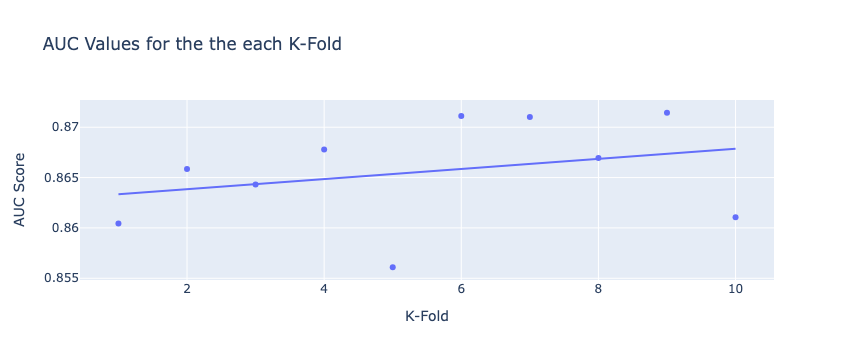

In [21]:
X1 = df['Cleaned Text'] # features
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),  # Text to word-count vector
    ('tfidf', TfidfTransformer()),  # TF-IDF transformation
    ('model', final_model)  # SVM
])

model_for_hypothesis_2(X1, y, pipe)

### Model 1: Use GloVe Embedding (Version 1)

- **Column used: "Cleaned Text"**
- **Model: SVM**
- **Feature Extraction: GloVe Embedding**
Description:

GloVe is designed to capture the semantic relationships and meaning of words based on their co-occurrence statistics in large text corpora. Its key advantage is its ability to capture word semantics and relationships through the distributional information in large text corpora. The resulting word vectors can be used as features in NLP 

**Approach: Average Word Embeddings with GloVe**

Explanation:
The approach calculates the average word embeddings for each text sequence. Each document is represented as an average of word vectors.

Pros:
Dimensionality reduction: The feature matrix has a lower dimensionality compared to direct document vectors.
Simplicity: Averages can capture the overall meaning of the text while reducing the feature space.

Cons:
Loss of word order: Averaging word embeddings doesn't capture word order information, which might be important in some cases.
May not capture all nuances: Averaging can simplify the representation and might not capture nuanced differences in text.



**Feature Transformation: nil** 

Explanation:
There isn't a for need additional feature transformation steps like TF-IDF, PCA, or LDA because the word embeddings themselves already capture a dense, distributed representation of words. GloVe word embeddings inherently contain semantic and contextual information.

In the case of GloVe embeddings, each word is represented as a high-dimensional vector, and these vectors capture relationships between words based on their co-occurrence statistics in the training corpus. This means that words with similar meanings or contexts will have similar vector representations.

Therefore, we can directly use GloVe word embeddings as features for your text classification model without the need for feature transformation steps

**Pre-Trained GloVe Embedding Model**

The pre-trained GLoVe embedding we used was trained on twitter datasets. We decided that this would be most appropriate as our project is involving social media posts and comments.

Link to GloVe Embeddings: https://nlp.stanford.edu/projects/glove/

#### Version 1
In this version, we experimented calculating the average word embeddings for each text sequence. Each document is represented as an average of word vectors. We decided to explore how well the individual words can help us to predict whether a post will be classified as stressed.

In [22]:
# Tokenize the text and pad sequences
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 100
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

# Load GloVe embeddings
glove_path = 'glove.twitter.27B.100d.txt' 
glove_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_index[word] = vector

# Create a feature matrix with average word embeddings using GloVe
feature_matrix = np.array([
    np.mean([glove_index.get(word, np.zeros(embed_vector_len)) for word in tokenizer.sequences_to_texts([seq])[0].split()], axis=0)
    for seq in sequences
])

The average accuracy is: 59.45%
The average classification error is: 40.55%
The average recall is: 100.00%
The average precision is: 59.40%
The average specificity is: 0.24%
The average f1 score is: 74.54%
The average AUC Score is: 81.62%


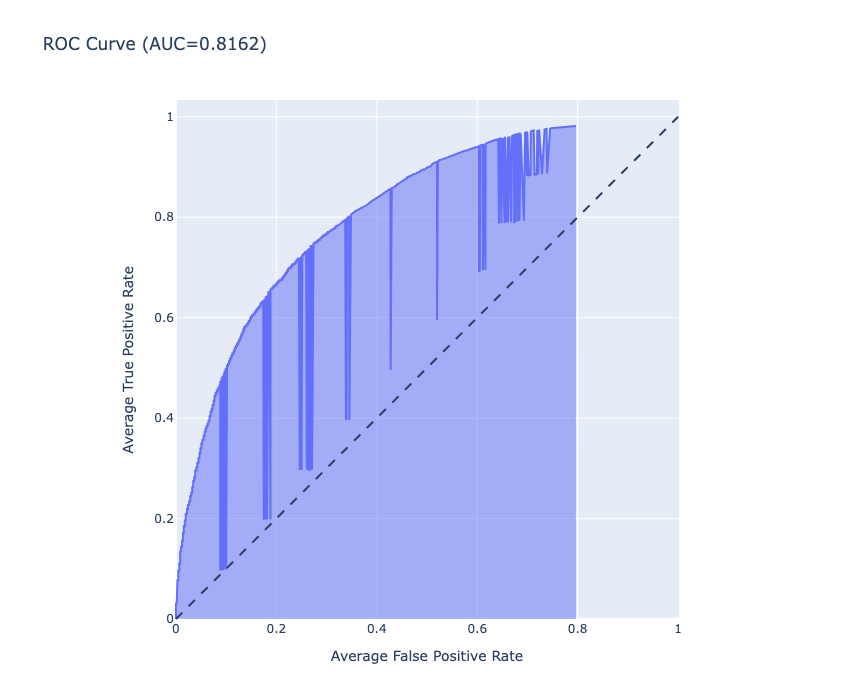

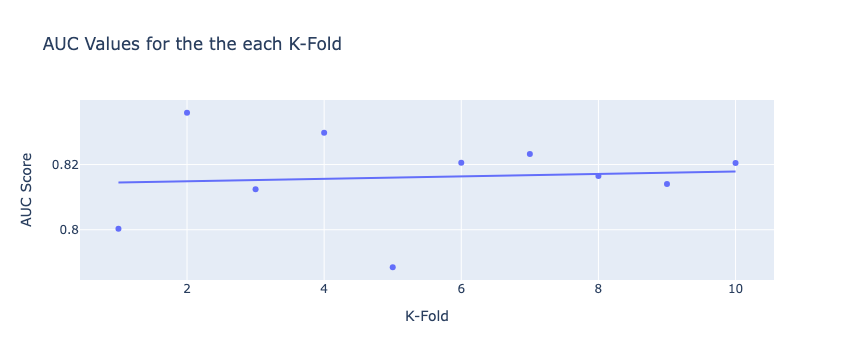

In [23]:
# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(feature_matrix, y, pipe)

#### Experimenting with different vector sizes
Since GloVe embeddings are pretrained with specific parameters (window,min_count,vector_size) that can't be changed, we ran our model with different vector sizes of 50, 100 and 200 to compare which vector size would be most appropriate.

##### Vector Size of 50

The average accuracy is: 59.38%
The average classification error is: 40.62%
The average recall is: 100.00%
The average precision is: 59.37%
The average specificity is: 0.08%
The average f1 score is: 74.51%
The average AUC Score is: 81.04%


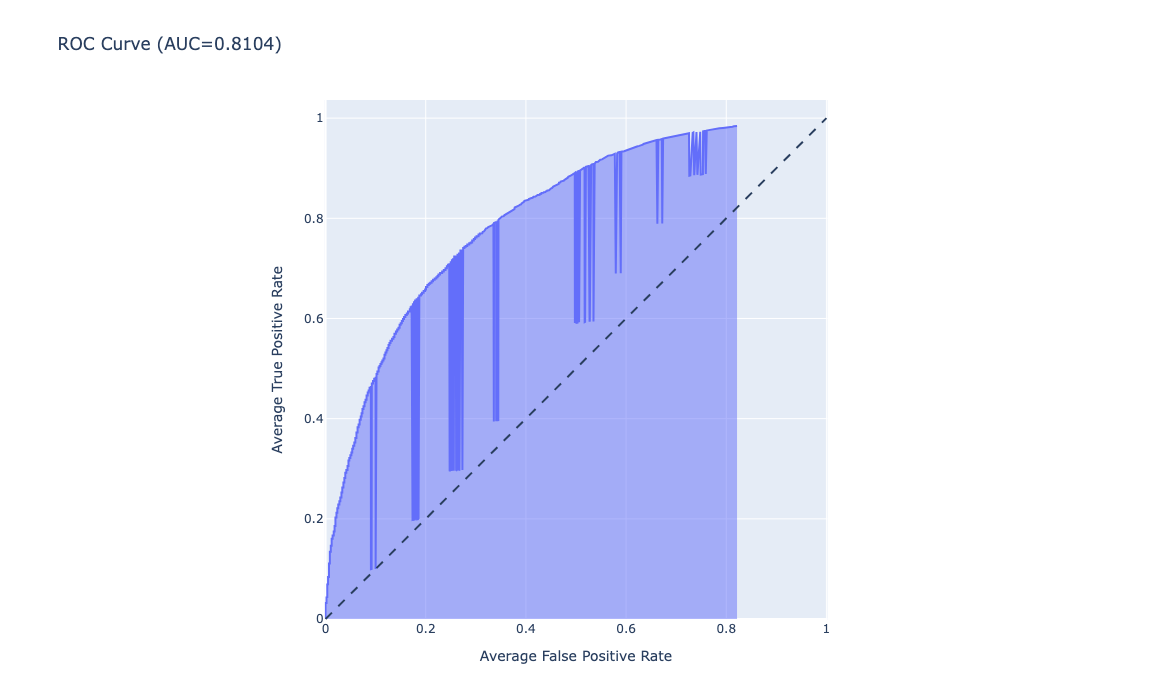

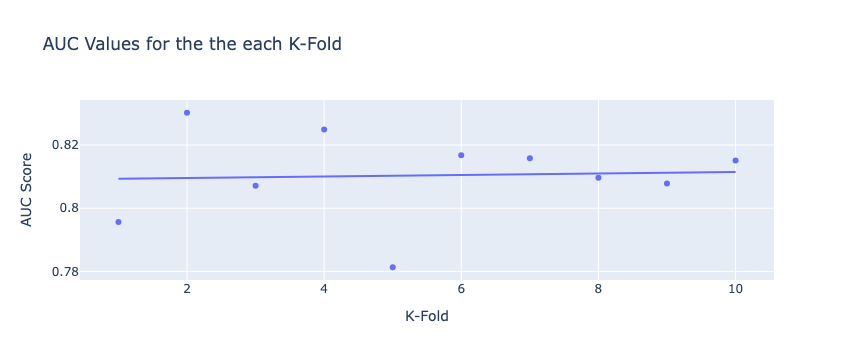

In [27]:
# Tokenize the text and pad sequences
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 50
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

# Load GloVe embeddings
glove_path = 'glove.twitter.27B.50d.txt' 
glove_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_index[word] = vector

# Create a feature matrix with average word embeddings using GloVe
feature_matrix = np.array([
    np.mean([glove_index.get(word, np.zeros(embed_vector_len)) for word in tokenizer.sequences_to_texts([seq])[0].split()], axis=0)
    for seq in sequences
])
# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(feature_matrix, y, pipe)

##### Vector Size of 100

In [26]:
# Tokenize the text and pad sequences
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 200
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

# Load GloVe embeddings
glove_path = 'glove.twitter.27B.100d.txt' 
glove_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_index[word] = vector

# Create a feature matrix with average word embeddings using GloVe
feature_matrix = np.array([
    np.mean([glove_index.get(word, np.zeros(embed_vector_len)) for word in tokenizer.sequences_to_texts([seq])[0].split()], axis=0)
    for seq in sequences
])
# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(feature_matrix, y, pipe)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (115,) + inhomogeneous part.

##### Vector Size of 200

The average accuracy is: 59.50%
The average classification error is: 40.50%
The average recall is: 100.00%
The average precision is: 59.43%
The average specificity is: 0.36%
The average f1 score is: 74.56%
The average AUC Score is: 81.99%


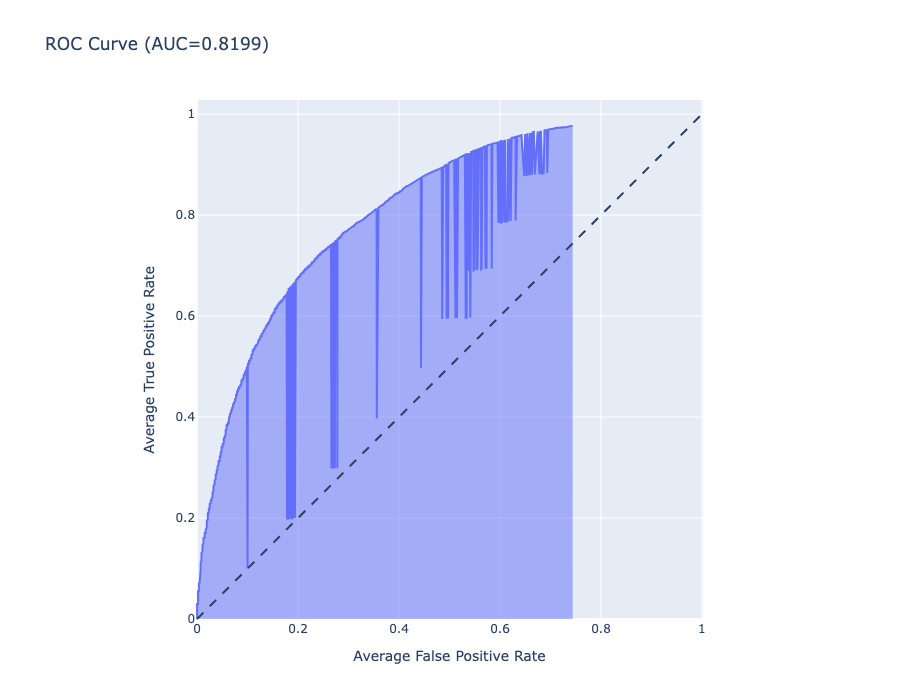

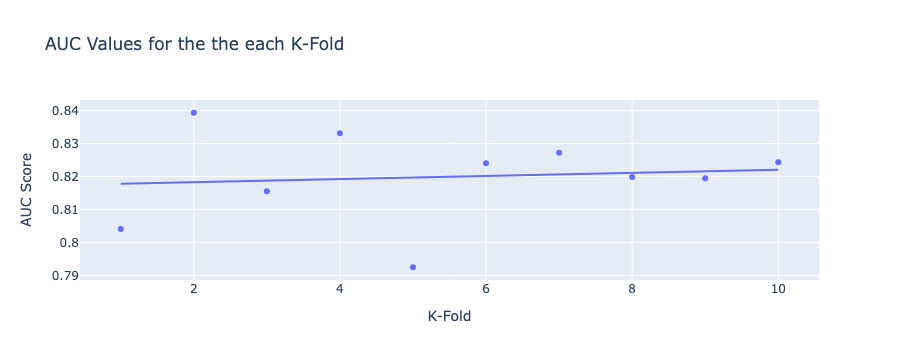

In [28]:
# Tokenize the text and pad sequences
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 200
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

# Load GloVe embeddings
glove_path = 'glove.twitter.27B.200d.txt' 
glove_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_index[word] = vector

# Create a feature matrix with average word embeddings using GloVe
feature_matrix = np.array([
    np.mean([glove_index.get(word, np.zeros(embed_vector_len)) for word in tokenizer.sequences_to_texts([seq])[0].split()], axis=0)
    for seq in sequences
])
# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(feature_matrix, y, pipe)

##### Conclusion
As expected, we achieved better results in both accuracy and F1-score, when using the largest vector size of 200(glove.twitter.27B.200d.txt). However, we have decided to stick with the glove embedding file with **100 dimensions(glove.twitter.27B.100d.txt)**, and vector size of 100 for all models, although it has a lower accuracy(59.38%) than the vector size of 200(accuracy score:59.50%), despite having the same recall for both vector sizes.

This is because our team agreed that we have started to observe diminishing returns with the increase in vector size, and the mere increase of 0.40-0.74% is not worth at the cost of using the larger file which is more computationally intensive, and will increase the complexity of model training.

### Model 2: Use GloVe Embedding (Version 2)

- **Column used: "Cleaned Text"**
- **Model: SVM**
- **Feature Extraction: GloVe Embedding**
Description:

GloVe is designed to capture the semantic relationships and meaning of words based on their co-occurrence statistics in large text corpora. Its key advantage is its ability to capture word semantics and relationships through the distributional information in large text corpora. The resulting word vectors can be used as features in NLP 
- **Approach: Direct GloVe Document Vectors**
Explanation:
The approach directly used GloVe embeddings for feature extraction. Each document or text sequence was represented as a single vector.

Pros:
Preserves semantic information: Using the entire vector representation of a document captures semantic relationships between words.
May capture nuances in the text that average word embeddings might miss.

Cons:
Larger feature space: Each document is represented as a high-dimensional vector, which can lead to a higher dimensionality.



- **Feature Transformation: nil** 
Explanation:
There isn't a for need additional feature transformation steps like TF-IDF, PCA, or LDA because the word embeddings themselves already capture a dense, distributed representation of words. GloVe word embeddings inherently contain semantic and contextual information.

In the case of GloVe embeddings, each word is represented as a high-dimensional vector, and these vectors capture relationships between words based on their co-occurrence statistics in the training corpus. This means that words with similar meanings or contexts will have similar vector representations.

Therefore, we can directly use GloVe word embeddings as features for your text classification model without the need for feature transformation steps

#### Version 2
In this version, we experimented with representing each document as a single vector by directly using the pre-trained Glove Embeddings. Our thought process is that this version should perform better because it retains the semantic information of the entire document.


In [29]:
# Tokenize the text and pad sequences
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 100
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

# Load GloVe embeddings
glove_path = 'glove.twitter.27B.100d.txt'  # Replace with your GloVe file path
glove_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_index[word] = vector

# Create document vectors using GloVe embeddings
document_vectors = []
for text in df['Cleaned Text']:
    words = text.split()
    vectors = [glove_index.get(word, np.zeros(embed_vector_len)) for word in words]
    doc_vector = np.mean(vectors, axis=0)
    document_vectors.append(doc_vector)

# Convert the list of document vectors to a NumPy array
feature_matrix = np.array(document_vectors)

The average accuracy is: 59.45%
The average classification error is: 40.55%
The average recall is: 100.00%
The average precision is: 59.40%
The average specificity is: 0.24%
The average f1 score is: 74.54%
The average AUC Score is: 81.60%


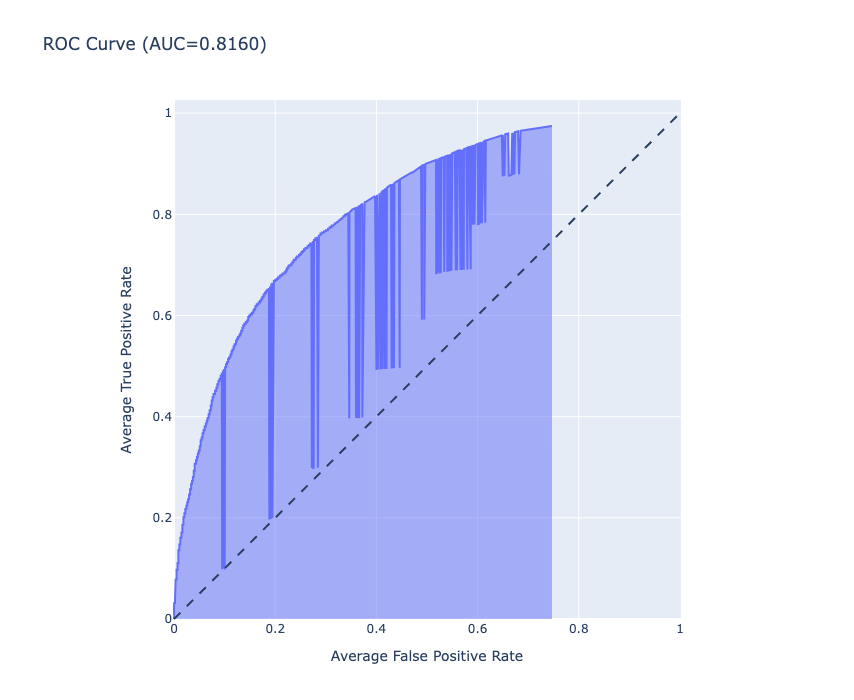

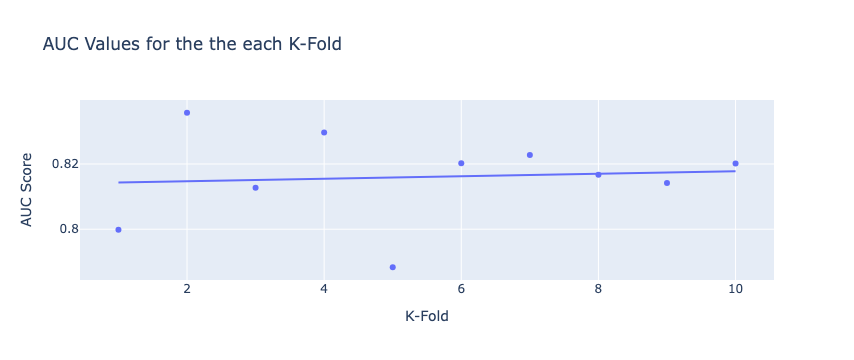

In [30]:
# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(feature_matrix, y, pipe)

#### Interesting Observations

The second version of the model performed quite abit better than the first version. The accuracy decreased slightly from 59.50% to 59.45%. However, the recall for both models remain the same at 100%. We hypothesised that this could be due to the fact that averaging the word embeddings already capture most of the semantic information in the text, or due to complexity of the terms in the dataset.

### Model 3: Word2Vec

- **Column used: "Cleaned Text"**
- **Model: SVM**
- **Feature Extraction: Word2Vec Embedding by Google**

Description:

Word2Vec is a powerful natural language processing technique for capturing semantic relationships and word context within text data. It generates word embeddings, which are dense vector representations of words, by considering the co-occurrence patterns of words in a large corpus of text. These word embeddings encode semantic information and can be leveraged as feature vectors for various text processing tasks. 

While we thought it would have been more interesting to train our own Word2Vec model, it was too computationally intensive for our CPU, and we decided to capitalise on Google's pre-trained vectors that have been trained on about 100 billion words from the Google News dataset. The model has 300-dimensional vectors for about 3 million words and phrases.

Link to Pre-trained Word2Vec Embeddings: https://code.google.com/archive/p/word2vec/

Pros:

Semantic understanding: Captures semantic relationships between words, and words with similar meanings are represented as vectors that are close in the vector space. This enhances the ability of Word2Vec to capture the meaning of words and phrases effectively.

Contextual information: Considers the context in which words appear, enabling it to distinguish between different uses of the same word based on the neighbouring words. This contextual understanding is important for tasks like word analogy and text similarity.

Smaller feature space: Unlike traditional bag-of-words models, Word2Vec generates relatively low-dimensional vectors, making it computationally efficient and well-suited for downstream machine learning models.

Cons:

Data dependency: The effectiveness is highly dependent on the quality and quantity of the training data. It requires a substantially large amount of text data to capture meaningful word relationships, which may not be available in certain cases.

Out-of-vocabulary words: Word2Vec may have difficulty with out-of-vocabulary words if they are not seen during training. Handling such words requires additional techniques or using subword embeddings like FastText.

Feature Transformation: None

Explanation:

Word2Vec embeddings provide a rich and semantically meaningful representation of words without the need for additional feature transformation. These embeddings are ready for use in various natural language processing tasks, including text classification, sentiment analysis, and document similarity, where capturing the meaning and context of words is crucial for accurate results.


The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 84.42%


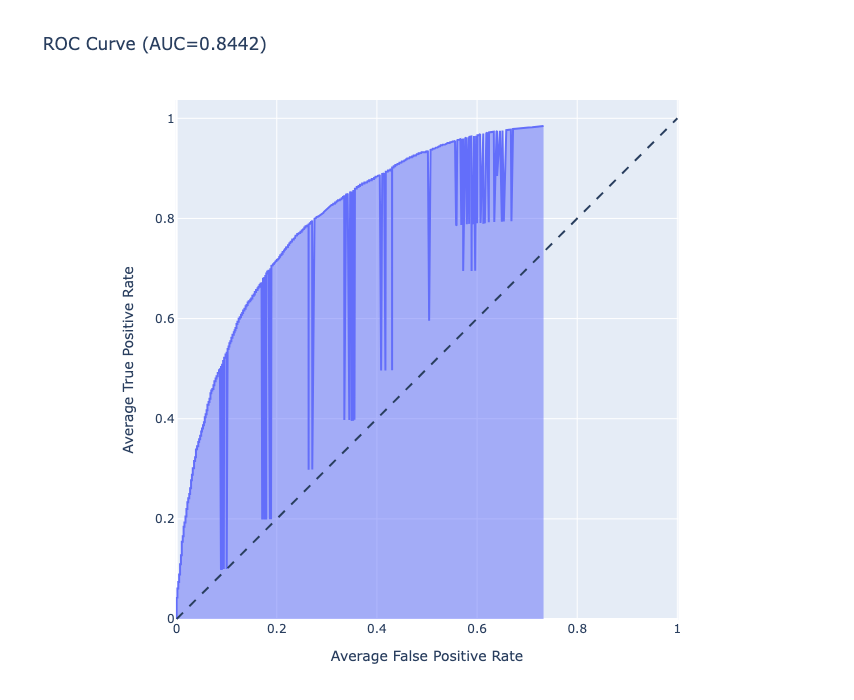

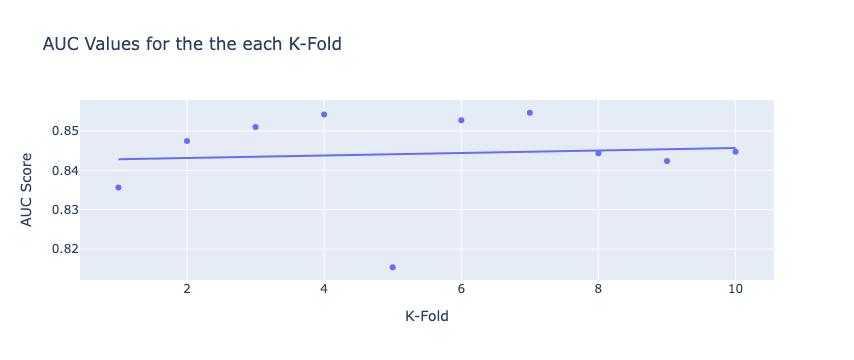

In [31]:
# Load the pre-trained Word2Vec model by Google
pretrained_model_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=True)

# Tokenize and pad text
texts = df['Cleaned Text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
maxLen = 150
sequences = pad_sequences(sequences, maxlen=maxLen)

# Create an embedding matrix
vocab_len = len(tokenizer.word_index) + 1
embed_vector_len = 300  
embedding_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_vector = word2vec_model[word]
        embedding_matrix[index] = embedding_vector

# Create a feature matrix with average word embeddings
feature_matrix = np.array([
    np.mean([embedding_matrix[word_idx] for word_idx in seq if word_idx != 0], axis=0)
    for seq in sequences
])

# # Create K-Fold splitter for 10 folds
# num_of_folds = 10
# skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=460)
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])

model_for_hypothesis_2(feature_matrix, y, pipe)

### Model 4: FastText

- **Column used: "Cleaned Text"**
- **Model: SVM**
- **Feature Extraction: FastText Embedding**

Description:

FastText is an effective method for capturing the semantics and context of words through subword information. It excels in handling out-of-vocabulary words and languages with rich morphology. FastText generates word embeddings based on character-level n-grams and their co-occurrence statistics in text data. These embeddings are valuable features for natural language processing tasks.

Pros:
Subword information: FastText can handle out-of-vocabulary words and complex word forms, making it suitable for diverse languages.
Contextual understanding: FastText embeddings capture the semantics and context of words, offering a rich feature representation for text data.

Cons:
Larger feature space: Each document is represented as a high-dimensional vector, potentially leading to a higher dimensionality.



- **Feature Transformation: nil** 
Explanation:
No additional feature transformation steps are necessary. FastText word embeddings inherently capture subword information, semantics, and contextual understanding. These embeddings offer a dense, distributed representation of words, enabling direct use as features for text classification without the need for further feature transformation.





In [32]:

# Tokenize the text (assuming "cleaned_text" contains your preprocessed text data)
sentences = df["Cleaned Text"].apply(lambda x: x.split())

# Train FastText model
fasttext_model = FastText(sentences, vector_size=300, window=10, min_count=1, sg=1)

# Create a feature matrix
features = np.array([np.mean([fasttext_model.wv[word] for word in sentence if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for sentence in sentences])


The average accuracy is: 59.66%
The average classification error is: 40.34%
The average recall is: 100.00%
The average precision is: 59.54%
The average specificity is: 0.77%
The average f1 score is: 74.63%
The average AUC Score is: 79.96%


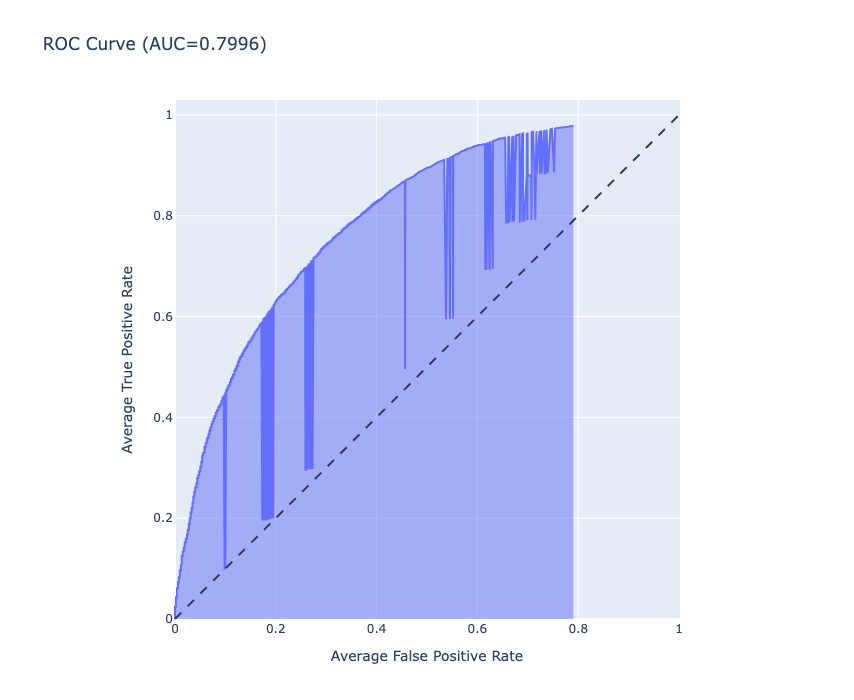

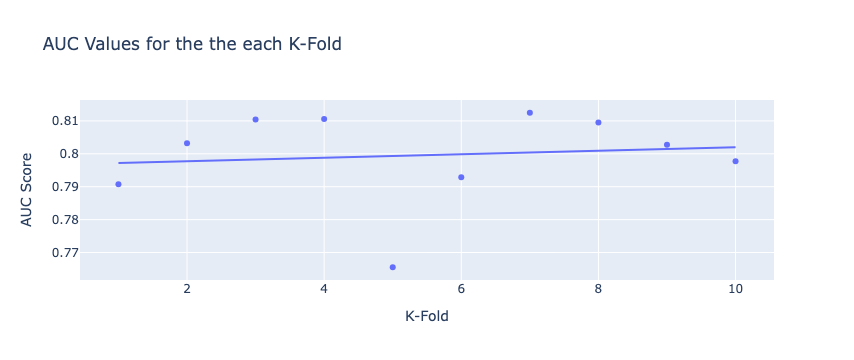

In [33]:
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(features, y, pipe)

#### Tuning Hyperparameters of FastText embedding
Method: RandomsearchCV

In [34]:
def evaluate_model(X, y, model):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    score = accuracy_score(y_test, y_pred)

    return score

# Define the hyperparameters
vector_sizes = [100, 200, 300]
windows = [5, 10, 15]
min_counts = [1, 2, 3]
sgs = [0, 1]

best_score = 0
best_params = {}

# Loop over each combination of hyperparameters
for vector_size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            for sg in sgs:
                # Train FastText model
                model = FastText(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

                # Create a feature matrix
                features = np.array([np.mean([model.wv[word] for word in sentence if word in model.wv] or [np.zeros(vector_size)], axis=0) for sentence in sentences])

                # Create a pipeline
                pipe = Pipeline([
                    ('model', final_model)  # SVM
                ])

                # Evaluate the model on a validation set
                score = evaluate_model(features, y, pipe)
                
                # If the score is better than the current best score, update the best score and best parameters
                if score > best_score:
                    best_score = score
                    best_params = {'vector_size': vector_size, 'window': window, 'min_count': min_count, 'sg': sg}

print('Best score:', best_score)
print('Best parameters:', best_params)



Best score: 0.7017055342847198
Best parameters: {'vector_size': 100, 'window': 15, 'min_count': 3, 'sg': 0}


In [35]:

# Tokenize the text (assuming "cleaned_text" contains your preprocessed text data)
sentences = df["Cleaned Text"].apply(lambda x: x.split())

# Train FastText model
fasttext_model = FastText(sentences, vector_size=100, window=15, min_count=3, sg=0)

# Create a feature matrix
features = np.array([np.mean([fasttext_model.wv[word] for word in sentence if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for sentence in sentences])


The average accuracy is: 72.15%
The average classification error is: 27.85%
The average recall is: 93.43%
The average precision is: 69.84%
The average specificity is: 41.09%
The average f1 score is: 79.93%
The average AUC Score is: 80.36%


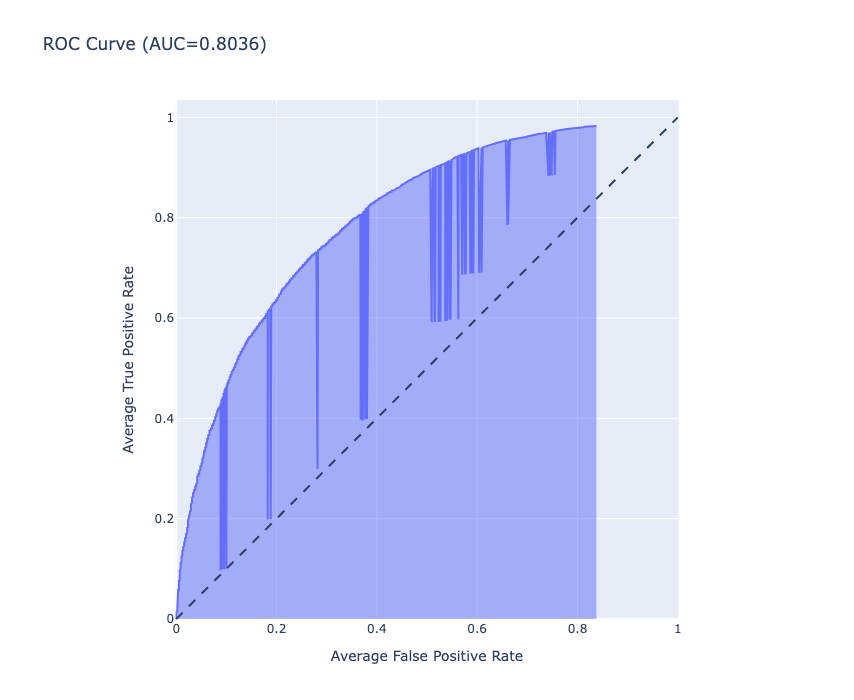

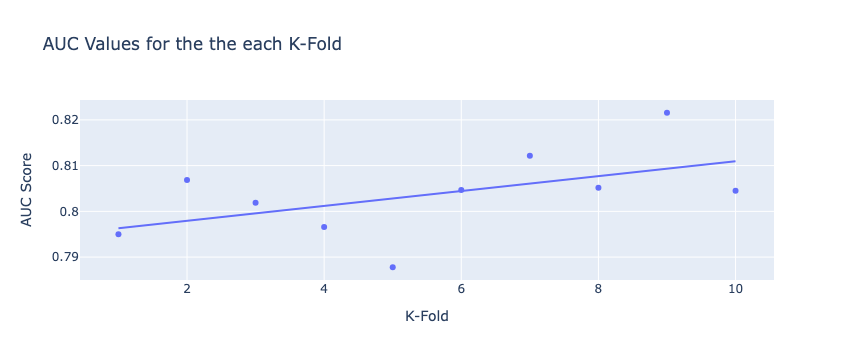

In [36]:
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(features, y, pipe)

#### Results of Hyperparameter Tuning of Embedding
After tuning the FastText embedding, accuracy improved significantly from 59.66% to 72.15% which is a 12.49% increase although recall decreased from 100% to 93.43% for a difference of 6.57%. The tuning took 1.5 hours to run, but the improvements are still pretty small, and hence we will prioritise the actual hyperparameter tuning of the models instead of the embeddings.

### Model 5: Doc2Vec

In [37]:
# Create TaggedDocument objects for Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df["Cleaned Text"])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=300, window=10, min_count=1, epochs=10)

# Create feature vectors for text data
features = np.array([doc2vec_model.dv[i] for i in range(len(documents))])

The average accuracy is: 59.35%
The average classification error is: 40.65%
The average recall is: 100.00%
The average precision is: 59.35%
The average specificity is: 0.00%
The average f1 score is: 74.49%
The average AUC Score is: 76.21%


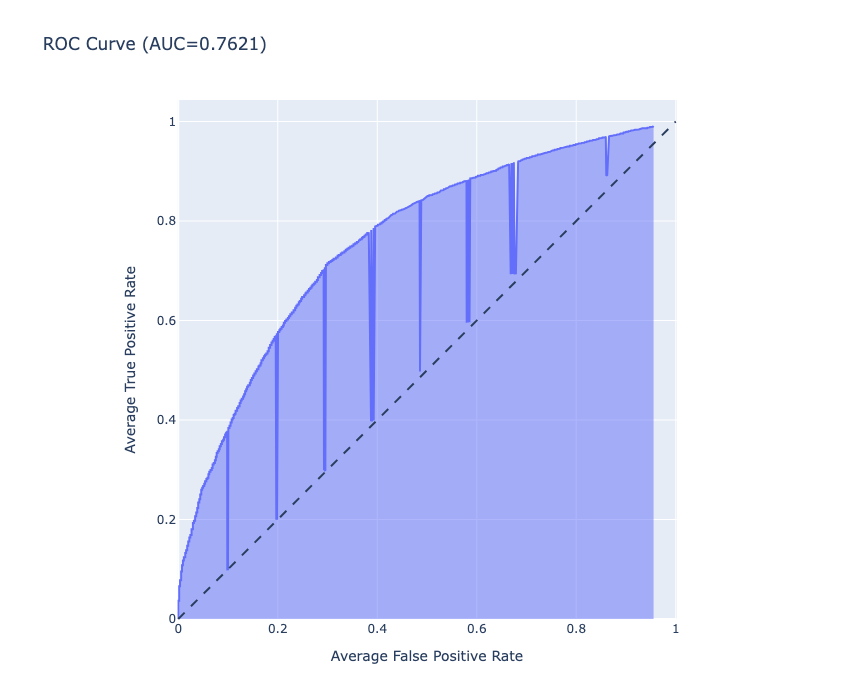

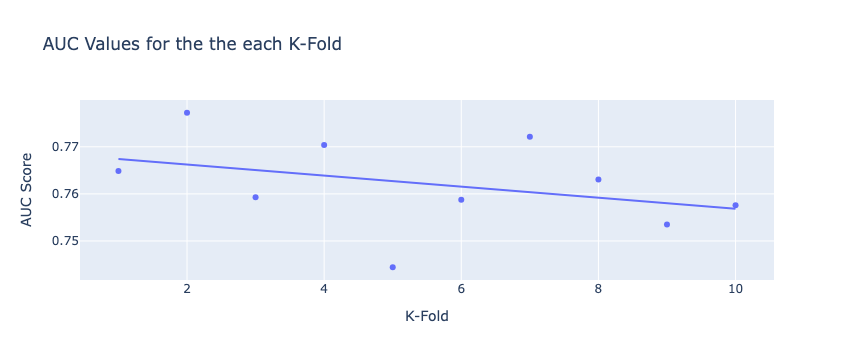

In [38]:
y = df['Label']

# Create a pipeline
pipe = Pipeline([
    ('model', final_model)  # SVM
])


model_for_hypothesis_2(features, y, pipe)